In [172]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch # import pytorch
import torchvision
from PIL import Image
from torch import optim, nn
from torchvision import datasets, transforms, models
from torch.utils import data
from torch.autograd import Variable
import time
import copy

print(torch.__version__) # find out the version of pytorch

1.1.0


In [173]:
print(os.listdir('../input'))
#find out the train and test data directories
print(os.listdir('../input/flower_data/flower_data'))
print(os.listdir('../'))

['cat_to_name.json', 'flower_data']
['train', 'valid']
['lib', 'input', 'config', 'working']


## Load data

In [174]:
# Transform the image (scaling, flipping and normalisation)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../input/flower_data/flower_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

#info about no. of datapoints
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 6552
     Root location: ../input/flower_data/flower_data/train,
 'valid': Dataset ImageFolder
     Number of datapoints: 818
     Root location: ../input/flower_data/flower_data/valid}

In [175]:
#Create the data loaders
batch_size = 64
# trainLoader = data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=False)
# testLoader = data.DataLoader(image_datasets['valid'], batch_size=batch_size, shuffle=False)

dataloaders = {x: data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) 
                   for x in ['train', 'valid']}

In [177]:
def show(image):
    if isinstance(image, torch.Tensor):
        image = image.numpy().transpose((1, 2, 0))
    else:
        image = np.array(image).transpose((1, 2, 0))
    # denormalisation
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    # plot
    fig, Xaxis = plt.subplots(1, 1, figsize=(9, 9))
    %matplotlib inline
    plt.imshow(image)
    Xaxis.axis('off') 

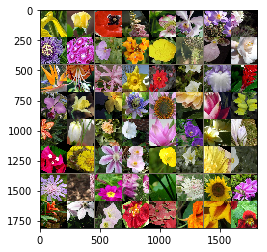

In [178]:
# Make a grid from batch (for training data)
# This grid shows the images which are present in 1 batch
images, _ = next(iter(dataloaders['train']))
trainGrid = torchvision.utils.make_grid(images, nrow=8)

show(trainGrid)

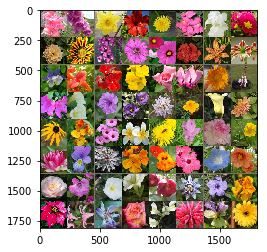

In [179]:
# Make a grid from batch (for validation/test data)
images, _ = next(iter(dataloaders['valid']))
testGrid = torchvision.utils.make_grid(images, nrow=8)

show(testGrid)

In [180]:
classNames = image_datasets['train'].classes

#Get labels to class names from json file
import json
with open('../input/cat_to_name.json', 'r') as f:
    labelToName = json.load(f)

# print(image_datasets['train'].classes)
labelToName

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

### Transfer Learning - ResNet18

In [181]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [182]:
# TODO: Build and train your network
model = models.densenet121(pretrained = True)

for param in model.parameters():
    
    param.requires_grad = False

model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.1),
                                 nn.Linear(256, 128),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.1),
                                 nn.Linear(128, 102),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

model.to(device)

(Linear(in_features=256, out_features=128, bias=True),)

### Training model

In [ ]:
def train(model, trainloader, testloader, criterion, optimizer, epochs=5, print_every=40):
  
    steps = 0
    running_loss = 0
    for e in range(epochs):
        
        # Model in training mode, dropout is on
        model.train()
        for images, labels in trainloader:
            
            steps += 1
            
            # Flatten images into a 784 long vector
            #images.resize_(images.size()[0], -1)
            
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            if steps % print_every == 0:
                # Model in inference mode, dropout is off
                model.eval()
                
                # Turn off gradients for validation, will speed up inference
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion)
                
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
                
                running_loss = 0
                
                # Make sure dropout and grads are on for training
                model.train()

def validation(model, testloader, criterion):
  
    accuracy = 0
    test_loss = 0
    for images, labels in testloader:

        #images = images.resize_(images.size()[0], -1)
        
        images = images.to(device)
        labels = labels.to(device)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ## Calculating the accuracy 
        # Model's output is log-softmax, take exponential to get the probabilities
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label
        equality = (labels.data == ps.max(1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    return test_loss, accuracy

In [ ]:
# uncomment these two lines when you want to re-train

#train(model, dataloaders['train'], dataloaders['valid'], criterion, optimizer, epochs=12)
#validation(model, dataloaders['valid'], criterion)

In [183]:
# Save the checkpoint
'''
checkpoint = {'input_size': 1024,
              'output_size': 102,
              'epochs': 12,
              'classifier': model.classifier,
              'optimizer_state': optimizer.state_dict(),
              'mapping': image_datasets['train'].class_to_idx,
              'state_dict': model.state_dict()}
'''
# Save the checkpoint 
#torch.save(checkpoint, 'checkpoint.pth')
idx_to_class = {}
for x in image_datasets['train'].class_to_idx:
    idx_to_class[image_datasets['train'].class_to_idx[x]] = labelToName[x]

## Loading the checkpoint

In [184]:
# A function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    print('Loading checkpoint...')
    checkpoint = torch.load(filepath, map_location='cpu')
    model = models.densenet121(pretrained=True)
    model.classifier = checkpoint['classifier']
    model.optimizer_state = checkpoint['optimizer_state']
    model.mapping = checkpoint['mapping']
    model.load_state_dict(checkpoint['state_dict'])
    print('Done')
    return model

In [185]:
# print(os.listdir('../input/checkpoint'))
model = load_checkpoint('checkpoint.pth')

Loading checkpoint...
Done


## Model Inference

In [2]:
#Image Processing

def process_image(image):
    
    img = Image.open(image_path)
    
    if img.size[0] > img.size[1]:  #resizing the image
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
        
    #crop the image
    left_margin = (img.width-224)/2
    bottom_margin = (img.height - 224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    #normalising
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img - mean)/std
    
    #moving color channels to first dimention as expected by pytorch
    img = img.transpose((2,0,1))
    
    return img

In [ ]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [ ]:
image_path = data_dir + '#image path'
img = process_image(image_path)
imshow(img)

In [ ]:
#Predicting the class 

def predict(image_path, model, topk=5):
    
    print('Prediction on Flower Classification starts')
    model.eval()
    model.cpu()
    
    idx_to_class = {i: k for k, i in model.mapping.items()}
    
    #opening the image
    with Image.open(image_path) as image:
        image = process_image(image)
        
    #switching it to float tensor
    image = torch.FloatTensor([image])
    
    #feeding it through the model
    output = model.forward(image)
    
    #to determine the topk probability and labels
    topk_prob, topk_labels = torch.topk(output, topk)
    
    #taking exp() of image to cancel out the LogSoftmax
    topk_prob = topk_prob.exp()
    
    #assemble the lists
    topk_prob_arr = topk_prob.data.numpy()[0]
    topk_indexes_list = topk_labels.data.numpy()[0].tolist()
    print('topk_indexes_list', topk_indexes_list)
    print(topk_indexes_list[0])
    
    topk_labels_list = [idx_to_class[x] for x in topk_labels_list]
    print('topk_labels_list: ', topk_labels_list)
    
    topk_class_arr = [labelToName[str(x)] for x in topk_labels_list]
    print('topk_prob_arr: ', topk_prob_arr)
    print('topk_class_arr: ', topk_class_arr)
    print('Done')
    
    return topk_prob_arr, topk_class_arr

In [ ]:
predict(data_dir + 'iamge_path', model)

In [ ]:
#Final SANITY Checking

In [ ]:
def sanity_check(image_path, model):
    
    plt.figure(figsize = (6, 10))
    ax = plt.subplot(2,1,1)
    
    #setting the title
    flower_num = image_path.split('/')[2]
    title_ = labelToName[flower_num]
    
    #plotting flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    
    #to make prediction
    probs, flowers = predict(image_path, model)
    
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

In [ ]:
image_path = data_dir + 'image_path'
sanity_check(image_path, model)

In [190]:
# Function which picks number of random images from the provided directory
def getImages(numImages, dataDir, shuffle=True):
    data = datasets.ImageFolder(dataDir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    idx = indices[:]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, shuffle=shuffle
                    ,batch_size=numImages)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

tensor([55, 57,  6, 84, 72])


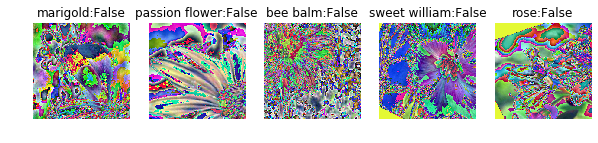

In [191]:
#inference step
test_dir = "../input/flower_data/flower_data/train"
to_pil = transforms.ToPILImage()
images,  labels = getImages(5,test_dir)
print(labels)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predictImages(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(idx_to_class[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()